[`make_classification` docs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification)

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from umap import UMAP

# work around for skrules import error
import six
import sys
sys.modules['sklearn.externals.six'] = six
from skrules import SkopeRules

## Set Up

In [2]:
n_clusters_per_class = 3

# for plotting
alpha = 0.3
size = 15

In [3]:
shap.initjs()

## Simulate Dataset

In [4]:
X, y = make_classification(
    n_samples=1000,
    n_features=50,
    n_informative=5,
    n_classes=2,
    n_clusters_per_class=n_clusters_per_class,
    weights=None,
    flip_y=0,
    class_sep=1.0, # larger values spread out the clusters/classes and make the classification task easier
    shift=None,
    scale=None,
    random_state=0
)

## Train Classifier

In [5]:
m = lgb.LGBMClassifier(random_state=0)
m.fit(X, y)

LGBMClassifier(random_state=0)

In [6]:
y_pred = m.predict(X)
acc = accuracy_score(y, y_pred)
acc

1.0

### Compute SHAP Values

In [7]:
explainer = shap.Explainer(m)
shap_values = explainer(X)

In [8]:
sv = shap_values.values[:, :, 1]

### Compare SHAP Values with Raw Values

In [9]:
np.abs(sv).mean(), np.abs(X).mean()

(0.21780279144749856, 51.3899262794928)

In [10]:
scale = np.abs(X).mean() / np.abs(sv).mean()
scale

235.94705071482227

In [11]:
df_sv = pd.DataFrame(sv)
df_sv.columns = [f"feat{n}" for n in range(X.shape[1])]
df_sv["y"] = y
df_sv["shap"] = 1

df_raw = pd.DataFrame(X)
df_raw.columns = [f"feat{n}" for n in range(X.shape[1])]
df_raw = df_raw / scale
df_sv["y"] = y
df_raw["shap"] = 0

df_all = pd.concat([df_raw, df_sv], axis=0, ignore_index=True)
df_all

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat42,feat43,feat44,feat45,feat46,feat47,feat48,feat49,shap,y
0,0.223488,-0.224365,0.074103,-0.002841,-0.376604,0.093613,0.097197,0.022128,0.240660,-0.007938,...,0.550216,0.416987,0.346913,-0.132439,-0.488521,0.068080,0.562959,0.097215,0,NaN
1,0.257070,0.125521,0.001171,-0.051368,0.349693,-0.053462,0.053832,-0.056925,-0.591250,0.001952,...,0.291187,0.459225,0.018568,0.211159,-1.527774,-0.091094,0.584209,0.172324,0,NaN
2,0.083340,0.236366,0.006147,0.012653,-0.288464,-0.325682,-0.068682,0.291722,-0.613364,-0.001625,...,0.032459,-0.149574,0.388573,-0.511184,-0.180258,-0.130764,0.625296,0.156919,0,NaN
3,0.247970,-0.196669,0.003343,0.020357,-0.331786,-0.055852,0.051022,0.198262,-0.172690,-0.006297,...,0.212458,-0.068677,-0.259847,0.371441,-0.096504,0.099703,0.183548,-0.067370,0,NaN
4,0.168314,0.243571,0.125883,0.016870,0.185304,0.083063,0.105457,-0.324885,-0.431488,0.014014,...,-0.068515,-0.069729,0.458562,0.121192,-0.038790,-0.155764,-0.733565,0.298820,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.022057,0.011486,-0.095940,-0.091538,0.015523,0.060115,-0.021878,-1.490833,-0.042670,-0.230609,...,-0.031989,-0.027648,-0.042086,0.018116,-2.569870,-0.012771,0.097374,0.002016,1,0.0
1996,-0.081043,-0.018183,-0.060937,-0.055459,0.033246,0.195361,0.056694,1.324953,0.009148,0.132811,...,-0.048990,0.069333,0.017894,0.002339,1.434147,0.039383,-0.003939,0.027753,1,1.0
1997,0.066847,0.013925,0.527991,0.058794,0.002158,0.045431,0.019556,0.055537,0.003644,-0.065026,...,0.374668,0.060095,0.027951,0.012013,-0.279417,0.032962,0.115485,0.065594,1,1.0
1998,0.033677,-0.025234,-0.162455,-0.092781,0.013674,-0.051122,-0.003615,-0.712531,0.015235,-0.018806,...,-0.134346,0.057482,-0.082284,-0.017571,-2.340177,-0.085890,0.056465,-0.006912,1,0.0


In [12]:
l = pd.melt(df_all, id_vars=["y", "shap"], value_vars=[f"feat{n}" for n in range(X.shape[1])])
l

,y,shap,variable,value
0,NaN,0,feat0,0.223488
1,NaN,0,feat0,0.257070
2,NaN,0,feat0,0.083340
3,NaN,0,feat0,0.247970
4,NaN,0,feat0,0.168314
...,...,...,...,...
99995,0.0,1,feat49,0.002016
99996,1.0,1,feat49,0.027753
99997,1.0,1,feat49,0.065594
99998,0.0,1,feat49,-0.006912


<AxesSubplot:xlabel='variable', ylabel='value'>

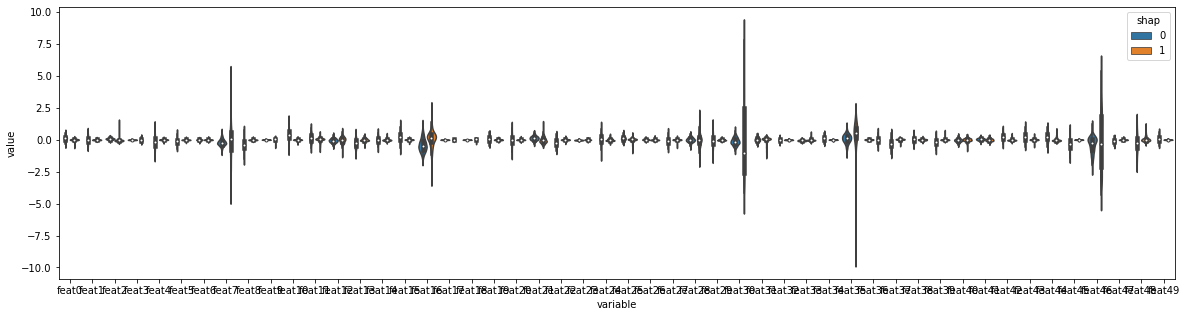

In [13]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.violinplot(x="variable", y="value", data=l, hue="shap", ax=ax)

## Dimensionality Reduction

In [14]:
def umap_embedding(
    values: np.array,
    n_components: int = 2,
    n_neighbors: int = 45,
    min_dist: float = 0.0,
    random_state: int = 0,
):
    embedding = UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state,
    ).fit_transform(values)
    return embedding

### Using Raw Values

In [15]:
# for colouring points in scatter plots
c = ["red"] * len(y)
for i in range(len(y)):
    if y[i] == 1:
        c[i] = "blue"

#### Both Classes

In [16]:
X_2d = umap_embedding(X)

The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11002. The TBB threading layer is disabled.


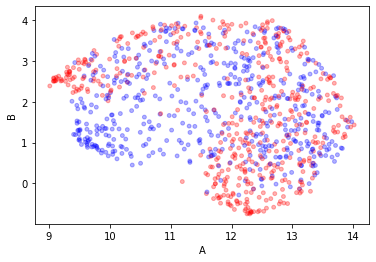

In [17]:
fig, ax = plt.subplots()
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(X_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax,
    scatter_kws={"alpha": alpha, "s": size, "color": c},
);

#### Positive Class Only

In [18]:
X_pos = X[y==1].copy()
X_p2d = umap_embedding(X_pos)

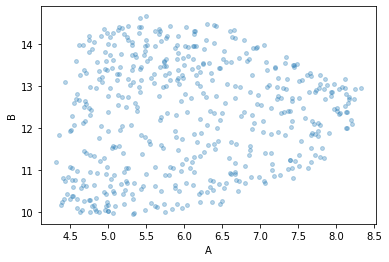

In [19]:
fig, ax = plt.subplots()
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(X_p2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax,
    scatter_kws={"alpha": alpha, "s": size},
);

### Using SHAP Values

#### Both Classes

In [20]:
sv_2d = umap_embedding(sv)

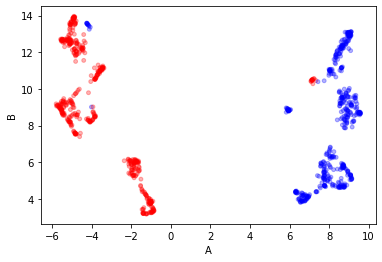

In [21]:
fig, ax = plt.subplots()
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(sv_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax,
    scatter_kws={"alpha": alpha, "s": size, "color": c},
);

#### Positive Class Only

In [22]:
sv_pos = sv[y==1].copy()
sv_p2d = umap_embedding(sv_pos)

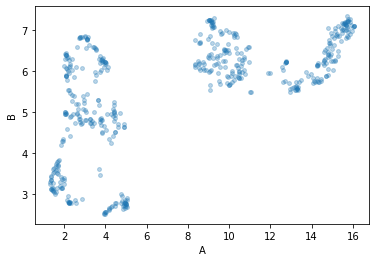

In [23]:
fig, ax = plt.subplots()
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(sv_p2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax,
    scatter_kws={"alpha": alpha, "s": size},
);

## Clustering

In [24]:
def cluster_labels(embedding: np.array, n_clusters: int, random_state: int = 0):
    return KMeans(n_clusters=n_clusters, random_state=0).fit(embedding).labels_

In [25]:
def get_cmap(cluster_labels):
    colours = [
        "#e60049",
        "#0bb4ff",
        "#50e991",
        "#e6d800",
        "#9b19f5",
        "#ffa300",
        "#dc0ab4",
        "#b3d4ff",
        "#00bfa0",
    ]
    cmap = []
    for l in cluster_labels:
        cmap.append(colours[l])
    return cmap

### Using Raw Embedding

In [26]:
X_2d_labels = cluster_labels(X_2d, n_clusters=n_clusters_per_class * 2)
X_cmap = get_cmap(X_2d_labels)

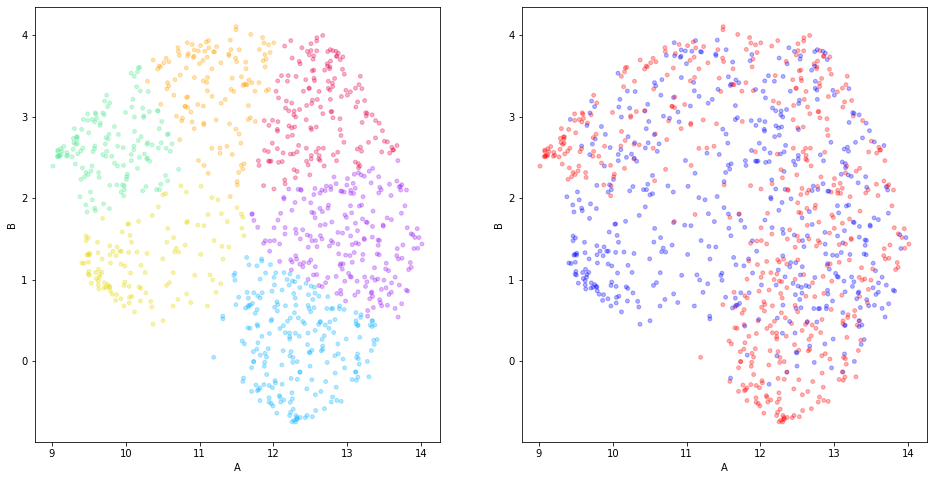

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(X_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax[0],
    scatter_kws={"alpha": alpha, "s": size, "color": X_cmap},
)
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(X_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax[1],
    scatter_kws={"alpha": alpha, "s": size, "color": c},
);

### Using SHAP Embedding

In [28]:
sv_2d_labels = cluster_labels(sv_2d, n_clusters=n_clusters_per_class * 2)
sv_cmap = get_cmap(sv_2d_labels)

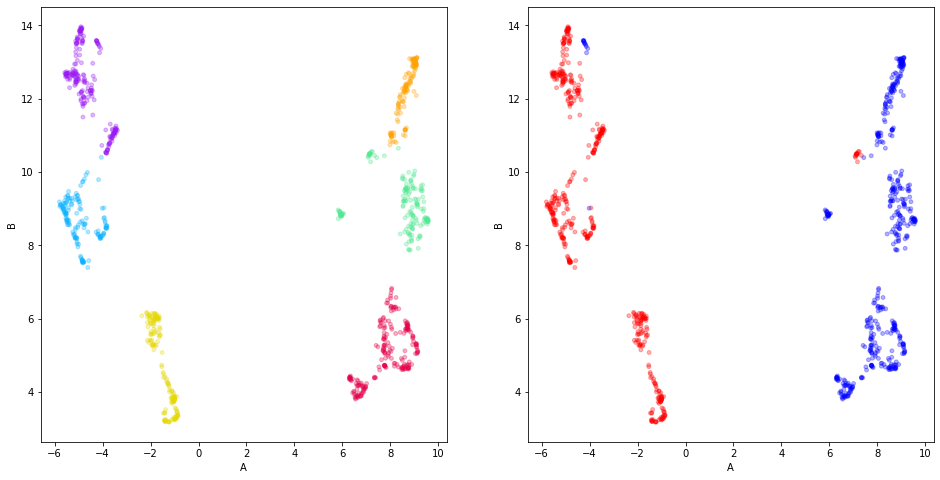

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(sv_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax[0],
    scatter_kws={"alpha": alpha, "s": size, "color": sv_cmap},
)
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(sv_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax[1],
    scatter_kws={"alpha": alpha, "s": size, "color": c},
);

## Cluster Descriptions

In [30]:
df_X = df_raw.drop("shap", axis=1)
df_X

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat40,feat41,feat42,feat43,feat44,feat45,feat46,feat47,feat48,feat49
0,0.223488,-0.224365,0.074103,-0.002841,-0.376604,0.093613,0.097197,0.022128,0.240660,-0.007938,...,0.013055,0.028001,0.550216,0.416987,0.346913,-0.132439,-0.488521,0.068080,0.562959,0.097215
1,0.257070,0.125521,0.001171,-0.051368,0.349693,-0.053462,0.053832,-0.056925,-0.591250,0.001952,...,-0.287203,0.045129,0.291187,0.459225,0.018568,0.211159,-1.527774,-0.091094,0.584209,0.172324
2,0.083340,0.236366,0.006147,0.012653,-0.288464,-0.325682,-0.068682,0.291722,-0.613364,-0.001625,...,0.051421,0.209442,0.032459,-0.149574,0.388573,-0.511184,-0.180258,-0.130764,0.625296,0.156919
3,0.247970,-0.196669,0.003343,0.020357,-0.331786,-0.055852,0.051022,0.198262,-0.172690,-0.006297,...,-0.076145,0.108349,0.212458,-0.068677,-0.259847,0.371441,-0.096504,0.099703,0.183548,-0.067370
4,0.168314,0.243571,0.125883,0.016870,0.185304,0.083063,0.105457,-0.324885,-0.431488,0.014014,...,0.033030,-0.040675,-0.068515,-0.069729,0.458562,0.121192,-0.038790,-0.155764,-0.733565,0.298820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.242034,-0.143521,0.091038,-0.004008,-0.619720,-0.190094,0.017033,-0.000601,-0.069469,-0.016363,...,0.129340,0.107284,0.575819,0.284237,-0.236929,0.332057,0.044368,-0.010960,-0.028225,0.639869
996,0.004941,0.163791,0.041794,-0.010988,-0.007156,-0.167921,-0.051010,-0.296396,-0.202305,0.027804,...,0.039527,-0.010701,0.138433,0.234027,-0.446391,-0.570334,-0.241854,-0.312070,-0.415214,-0.030000
997,0.315767,-0.170162,-0.046070,-0.042549,-0.244665,0.102445,0.090549,-0.136282,-0.482582,-0.013766,...,-0.173144,0.004100,0.010502,0.440388,-0.457790,0.097891,-0.146731,-0.202313,-0.108678,0.339589
998,0.156925,-0.085619,0.043279,-0.004739,-0.030042,-0.221038,-0.079832,-0.112626,-0.141737,0.003331,...,0.184414,-0.065213,0.368955,-0.028052,0.032728,-0.693402,-0.139500,-0.008284,-0.157971,-0.010589


In [71]:
def skoperules_models(
    X: pd.DataFrame,
    y: np.array,
    labels: np.array,
    n_estimators: int = 10,
    recall_min: float = 0.2,
    max_depth: int = 5,
    max_depth_duplication: int = 5,
    max_samples: float = 1.0,
    random_state: int = 0,
):
    X["cluster"] = labels
    sr_models = {}
    for cluster in X["cluster"].value_counts().index.sort_values():
        Xc = X.drop("cluster", axis=1)
        yc = (X["cluster"] == cluster) * 1
        sr = SkopeRules(
            feature_names=Xc.columns,
            random_state=random_state,
            n_estimators=n_estimators,
            recall_min=recall_min,
            max_depth=max_depth,
            max_depth_duplication=max_depth_duplication,
            max_samples=max_samples,
        )
        sr.fit(Xc, yc)
        sr_models[cluster] = sr
    return sr_models

In [72]:
sv_models = skoperules_models(df_X, y, sv_2d_labels)

In [73]:
for cluster in sv_models.keys():
    print(f"Cluster {cluster}")
    if len(sv_models[cluster].rules_) == 0:
        print("N/A")
    else:
        for i, rule in enumerate(sv_models[cluster].rules_):
            print(rule)

Cluster 0
('feat28 <= 0.06297464296221733 and feat30 <= 0.030512599274516106 and feat35 > -0.33516286313533783 and feat46 <= -0.1970827952027321 and feat7 > -0.436997190117836', (0.7345679012345679, 0.5586854460093896, 20))
('feat30 <= 0.030512599274516106 and feat35 > -0.33516286313533783 and feat45 <= 0.5308916121721268 and feat46 <= -0.1970827952027321 and feat7 <= -0.436997190117836', (0.9827586206896551, 0.2676056338028169, 10))
('feat30 <= 0.030512599274516106 and feat35 > -0.33516286313533783 and feat37 > -1.0188997983932495 and feat46 <= -0.1970827952027321 and feat7 <= -0.436997190117836', (0.9827586206896551, 0.2676056338028169, 10))
Cluster 1
('feat18 <= 0.004910777555778623 and feat30 <= -0.11122395470738411 and feat46 > -0.4753788262605667 and feat7 > -0.060719311237335205', (1.0, 0.8791946308724832, 20))
Cluster 2
('feat28 <= 0.11192413046956062 and feat30 > 0.030512599274516106 and feat33 <= 0.08759761229157448 and feat35 > -0.3473440110683441 and feat46 <= -0.1439786180

In [74]:
sv_models[0].rules_[0][0].split("and")

['feat28 <= 0.06297464296221733 ',
 ' feat30 <= 0.030512599274516106 ',
 ' feat35 > -0.33516286313533783 ',
 ' feat46 <= -0.1970827952027321 ',
 ' feat7 > -0.436997190117836']

In [75]:
sv_models[1].rules_[0][0].split("and")

['feat18 <= 0.004910777555778623 ',
 ' feat30 <= -0.11122395470738411 ',
 ' feat46 > -0.4753788262605667 ',
 ' feat7 > -0.060719311237335205']

In [76]:
sv_models[2].rules_[0][0].split("and")

['feat28 <= 0.11192413046956062 ',
 ' feat30 > 0.030512599274516106 ',
 ' feat33 <= 0.08759761229157448 ',
 ' feat35 > -0.3473440110683441 ',
 ' feat46 <= -0.14397861808538437']

In [77]:
sv_models[3].rules_[0][0].split("and")

['feat16 > -0.744682103395462 ',
 ' feat35 <= -0.29090315103530884 ',
 ' feat39 <= 0.485760822892189 ',
 ' feat46 <= -0.530925065279007 ',
 ' feat7 > -0.46806296706199646']

In [78]:
sv_models[4].rules_[0][0].split("and")

['feat3 > -0.036842143163084984 ',
 ' feat30 <= 0.031288222409784794 ',
 ' feat46 > -0.13664789497852325 ',
 ' feat48 <= -0.21320047229528427 ',
 ' feat7 <= -0.06473453342914581']

In [79]:
sv_models[5].rules_[0][0].split("and")

['feat16 > -1.1124264597892761 ',
 ' feat20 <= 0.6811724901199341 ',
 ' feat30 > 0.04813159070909023 ',
 ' feat45 > -1.3842988014221191 ',
 ' feat46 > -0.1485435664653778']

In [ ]:
28, 30, 35, 46, 7, 18, 33